# [Paris Saclay Center for Data Science](http://www.datascience-paris-saclay.fr)

## [RAMP](https://www.ramp.studio/problems/sea_ice) on arctic sea ice prediction

_Balázs Kégl (CNRS), Camille Marini (CNRS), Andy Rhines (UW), Jennifer Dy (NEU), Arindam Banerjee (UMN)_

## Introduction

Arctic sea ice cover is one of the most variable features of Earth's climate. Its annual cycle peaks at around 15 million square kilometers in early spring, melting back to a minimum of about 6 million square kilometers in September. These seasonal swings are important for Earth's energy balance, as ice reflects the majority of sunlight while open water absorbs it. Changes in ice cover are also important for marine life and navigation for shipping.
![arctic min-max map](https://s3-us-west-2.amazonaws.com/artemp/arctic_min_max_map.png)

In recent years, Arctic sea ice cover has declined rapidly, particularly during the September minimum. These changes have outpaced the predictions of climate models, and forecasting extent remains a formidable challenge. Typically, skillful predictions are limited to ~2-5 months in advance [Stroeve, et al. "Improving Predictions of Arctic Sea Ice Extent"](https://eos.org/features/improving-predictions-of-arctic-sea-ice-extent), while idealized experiments suggest that predictions up to two years in advance should be possible [Guemas et al., 2014](http://onlinelibrary.wiley.com/doi/10.1002/qj.2401/abstract).

![sea ice](https://s3-us-west-2.amazonaws.com/artemp/sea-ice.jpg)

Better tools to predict ice cover are critical for seasonal and regional climate prediction, and would thus address grand challenges in the study of climate change ([World Climate Research Programme: Grand Challenges, 2013](http://wcrp-climate.org/grand-challenges)).


## The CCSM4 simulator

As a surrogate for observational data, we will use output from a 1300 year simulation using the NCAR [CCSM4.0](http://www.cesm.ucar.edu/models/ccsm4.0) climate model. The model was run in fully-coupled mode with interactive ocean, atmosphere, and sea ice. The simulation was also performed in an idealized "Pre-Industrial" mode, where greenhouse gas concentrations and other external forcings are held fixed to 1850 levels. This allows us to access a  stationary climate over a 1000+ year period, which makes the evaluation of the predictor more robust than if we used real measurements that are both non-stationary and limited to several decades.

## The data

The data is a time series of "images" $z_t$, consisting of different physical variables on a regular grid on the Earth, indexed by lon(gitude) and lat(itude) coordinates. The variables we have made available are: 
* `ice_area`: the Northern Hemisphere sea ice area, in millions of squared kilometers.
* `ts`: surface temperature, most important over the oceans which have a very high heat capacity.
* `taux`: zonal (x-direction) surface wind stress. This is the frictional effect of winds on the sea surface and sea ice.
* `tauy`: meridional (y-direction) surface wind stress.
* `ps`: surface pressure.
* `psl`: equivalent sea-level surface pressure. This corrects ps for the effects of topography, though the two should be very similar.
* `shflx`: Surface sensible heat flux, the amount of heat transferred from the surface to the atmosphere.
* `cldtot`: Total cloud cover (fractional), which has strong effects on radiative energy balance at the surface.

The fields are recorded every month for 1300 years, giving 15,600 time points. The goal is to predict the Northern Hemisphere sea ice area <span style="color:red">4 months ahead</span>. 

## The prediction task

The pipeline will consists of a time series feature extractor and a predictor. Since the task is regression, the predictor will be a regressor, and the score (to minimize) will be the (root mean square error)[http://en.wikipedia.org/wiki/Root-mean-square_deviation]. The feature extractor will have access to the whole data. It will construct a "classical" feature matrix where each row corresponds to a time point. You should collect all information into these features that you find relevant to the regressor. The feature extractor can take <span style="color:red">anything from the past</span>, that is, it will implement a function $x_t = g(z_1, \ldots, z_t)$. Since you will have access to the full data, in theory you can cheat (even inadvertently) by using information from the future. We have implemented a randomized test to find such "bugs", but please do your best to avoid this since it would make the results irrelevant.

## Domain-knowledge suggestions

You are of course free to explore any regression technique to improve the prediction. Since the input dimension is relatively large (2000+ dimensions per time point even after subsampling) sparse regression techniques (eg. LASSO) may be the best way to go, but this is just an a priori suggestion. The following list provides you other hints to start with, based on domain knowledge. 
* Some of the predictors will be very non-Gaussian.  
* Teleconnections such as those associated with El Nino can be very important, so do not restrict your attention to variables in the Arctic.

# Exploratory data analysis

Packages to install:

conda install xarray dask netCDF4 basemap<BR>

In [1]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

Let's start by reading the data into an xarray Dataset object. You can find all information on how to access and manipulate `Dataset` and `DataArray` objects at the [xarray site](http://xray.readthedocs.org/en/stable).

In [3]:
X_ds = xr.open_dataset('data/train.nc', decode_times=False)
y_array = np.load('data/train.npy') 

[`xarray`](http://xarray.pydata.org/en/stable/time-series.html) uses `datetime64[ns]` as a time type which means that dates must be between 1678 and 2262. We convert whatever time type we have into `datetime64[ns]` starting at 1700. This only works if the monthly time series has length less than 562 years, which is the case of all train and test times series, both in the starting kit and in the backend. This is important so that, e.g., grouping by month works correctly.

In [6]:
X_ds['time'] = pd.date_range(
    '1/1/1700', periods=X_ds['time'].shape[0], freq='M')\
    - np.timedelta64(15, 'D')

Printing it, you can see that it contains all the data, indices, and other metadata.

In [7]:
X_ds

<xarray.Dataset>
Dimensions:   (lat: 39, lon: 58, time: 1800)
Coordinates:
  * time      (time) datetime64[ns] 1700-01-16 1700-02-13 1700-03-16 ...
  * lat       (lat) float64 -90.0 -85.29 -80.58 -75.86 -71.15 -66.44 -61.73 ...
  * lon       (lon) float64 0.0 6.25 12.5 18.75 25.0 31.25 37.5 43.75 50.0 ...
Data variables:
    ice_area  (time) float64 14.06 14.87 14.84 13.89 12.31 10.41 8.343 6.773 ...
    ts        (time, lat, lon) float32 245.185 245.122 245.106 245.114 ...
    taux      (time, lat, lon) float32 0.0119357 0.00967538 0.00755875 ...
    tauy      (time, lat, lon) float32 0.0177472 0.0183095 0.0190735 ...
    ps        (time, lat, lon) float32 69120.7 69120.7 69120.7 69120.7 ...
    psl       (time, lat, lon) float32 100224.0 100224.0 100224.0 100224.0 ...
    shflx     (time, lat, lon) float32 -1.9265 -2.07657 -2.13199 -2.11077 ...
    cldtot    (time, lat, lon) float32 0.217556 0.217556 0.217556 0.217556 ...
Attributes:
    n_burn_in:    120
    n_lookahead:  4

`y_array` on the disk is already shifted by `n_lookahead = 4` months. `n_burn_in = 120` (months) is the length of the prefix for which no prediction is required. If your feature extractor only uses these ten years of the past to extract features from, you don't need to worry about missing data in the beginning of the sequence. Otherwise you should take care of the issue "manually" (handling missing data in the beginning of the sequence).

In [18]:
y_array, y_array.shape

(array([ 12.31275082,  10.41492558,   8.34265137, ...,  15.05521202,
         15.12392712,  14.23954105]), (1800,))

Past ice area is also part of the input, here you should be extremely careful not using it in the future.

In [19]:
X_ds['ice_area']

<xarray.DataArray 'ice_area' (time: 1800)>
array([ 14.056189,  14.867679,  14.841535, ...,   8.755171,  10.52556 ,
        12.80698 ])
Coordinates:
  * time     (time) datetime64[ns] 1700-01-16 1700-02-13 1700-03-16 ...
Attributes:
    units:      M km^2
    long_name:  Northern hemisphere sea ice area

Let's plot all spatiotemporal input at a certain time point. Time is measured in number of month after the first point which represents a January.

In [9]:
def plot_map(map_xr, time_index):

    lons, lats = np.meshgrid(map_xr['lon'], map_xr['lat'])

    fig = plt.figure()
    ax = fig.add_axes([0.05, 0.05, 0.9,0.9])
    map = Basemap(llcrnrlon=0, llcrnrlat=-89, urcrnrlon=360, urcrnrlat=89, projection='mill')
    # draw coastlines, country boundaries, fill continents.
    map.drawcoastlines(linewidth=0.25)
    #map.drawcountries(linewidth=0.25)
    #map.fillcontinents(color='coral',lake_color='aqua')
    # draw the edge of the map projection region (the projection limb)
    #map.drawmapboundary(fill_color='aqua')
    ax.set_title(map_xr.attrs['long_name'] + ' at month ' + str(time_index))
    im = map.pcolormesh(lons, lats, map_xr[time_index],
                        shading='flat', cmap=plt.cm.jet, latlon=True)
    cb = map.colorbar(im,"bottom", size="5%", pad="2%")

    #plt.savefig("test_plot.pdf")
    plt.show()

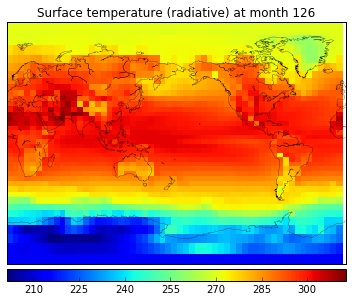

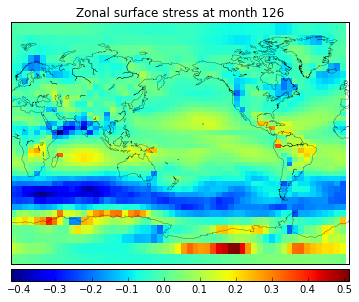

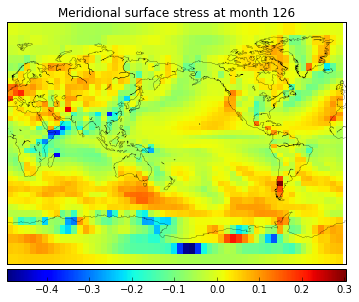

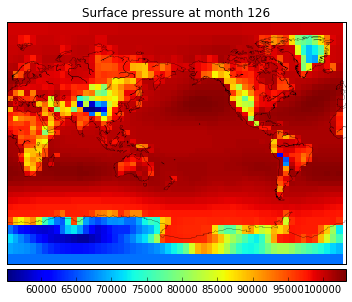

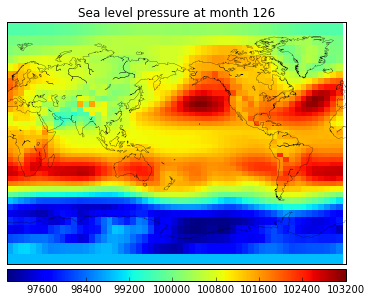

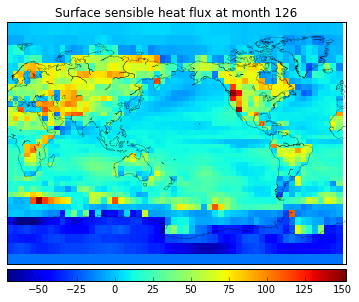

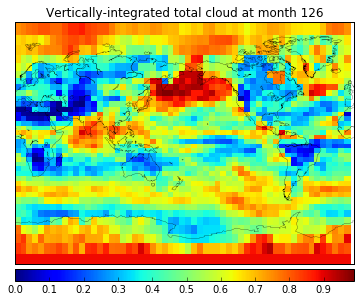

In [10]:
t = 126
plot_map(X_ds['ts'], t)
plot_map(X_ds['taux'], t)
plot_map(X_ds['tauy'], t)
plot_map(X_ds['ps'], t)
plot_map(X_ds['psl'], t)
plot_map(X_ds['shflx'], t)
plot_map(X_ds['cldtot'], t)

## The target.

The size of the Northern hemisphere sea ice area in million square kilometers, shifted by 4 months. Note that this variable is also part of the input (see above), shifted back so it is aligned with the other variables.

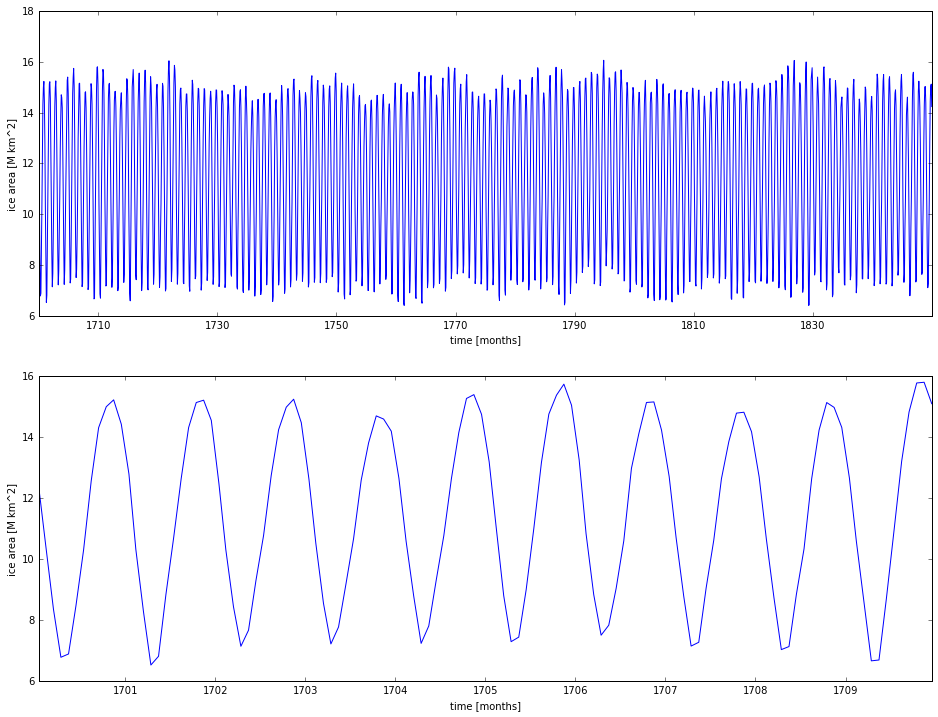

In [11]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(2, 1, 1)
ax.set_xlabel('time [months]')
ax.set_ylabel('ice area [M km^2]')
ax.plot(X_ds['time'], y_array)

ax = fig.add_subplot(2, 1, 2)
ax.set_xlabel('time [months]')
ax.set_ylabel('ice area [M km^2]')
ax.plot(X_ds['time'][:120], y_array[:120])

You can index xarray.DataArrays similarly to  <code>pandas</code> dataframes or <code>numpy</code> array. The result is always a <coda>DataArray</code>

In [12]:
t = 123
lat = 13
lon = 29

In [13]:
X_ds['ice_area'][t]

<xarray.DataArray 'ice_area' ()>
array(15.104208946228027)
Coordinates:
    time     datetime64[ns] 1710-04-15
Attributes:
    units:      M km^2
    long_name:  Northern hemisphere sea ice area

In [14]:
X_ds['ts'][t, lat]

<xarray.DataArray 'ts' (lon: 58)>
array([ 295.595917,  295.077911,  294.459259,  294.784088,  288.778809,
        291.563965,  298.488068,  297.634125,  297.555206,  297.538452,
        296.985779,  296.336151,  295.854889,  295.928864,  295.802582,
        295.874908,  295.745728,  295.77179 ,  296.79306 ,  292.079071,
        291.610535,  292.217377,  293.144531,  293.365082,  291.763672,
        297.667328,  296.720337,  296.548737,  296.528229,  296.442993,
        296.600342,  296.626129,  296.825836,  296.636566,  296.6008  ,
        296.299835,  296.133545,  296.138336,  296.254242,  296.246155,
        296.207275,  296.272217,  296.061768,  295.639862,  294.837006,
        293.281128,  292.998108,  291.669067,  295.59549 ,  293.546875,
        298.870697,  298.631134,  298.164978,  297.651123,  297.691742,
        297.313721,  296.688385,  296.033234], dtype=float32)
Coordinates:
    time     datetime64[ns] 1710-04-15
    lat      float64 -28.74
  * lon      (lon) float64 0.0 6

You can convert any of these objects into a <code>numpy</code> array.

In [15]:
X_ds['taux'].values

array([[[  1.19356960e-02,   9.67537798e-03,   7.55875325e-03, ...,
           1.18619325e-02,   1.09429900e-02,   1.22338524e-02],
        [  4.41878587e-02,   3.38704921e-02,   3.16834785e-02, ...,
           6.33927882e-02,   5.51564693e-02,   4.85668816e-02],
        [  1.48713449e-02,   9.71391704e-03,   4.09940118e-03, ...,
           1.94972251e-02,   2.16817427e-02,   1.50534194e-02],
        ..., 
        [  1.01837456e-01,   1.47577509e-01,   1.52642533e-01, ...,
          -7.09521398e-02,   2.52995710e-03,   5.99600412e-02],
        [  5.67872338e-02,   7.03624263e-02,   7.88953975e-02, ...,
           1.72229647e-03,   2.38575265e-02,   4.71802503e-02],
        [  7.66299218e-02,   7.68604428e-02,   7.69598857e-02, ...,
           7.20449910e-02,   7.48636052e-02,   7.62343481e-02]],

       [[  1.01154828e-02,   7.53489835e-03,   5.28584421e-03, ...,
           1.24596599e-02,   1.10400580e-02,   1.09038418e-02],
        [  2.70372722e-02,   1.82139259e-02,   1.79223008e-0

You can also use slices, and slice bounds don't even have to be in the index arrays.

In [16]:
X_ds['tauy'][12].loc[10:50]

<xarray.DataArray 'tauy' (lat: 8, lon: 58)>
array([[ 0.049768,  0.046843,  0.095759, ...,  0.038427,  0.029995,  0.046069],
       [ 0.01939 ,  0.041139,  0.039579, ...,  0.032233,  0.034647,  0.035988],
       [ 0.023434,  0.00317 ,  0.037727, ...,  0.027224,  0.010083,  0.036892],
       ..., 
       [-0.016391, -0.008304,  0.000831, ..., -0.053041, -0.041311, -0.039617],
       [-0.026566, -0.027404, -0.060934, ..., -0.098736, -0.113015, -0.319821],
       [-0.25397 , -0.374775, -0.134166, ..., -0.09506 , -0.117772, -0.080058]], dtype=float32)
Coordinates:
    time     datetime64[ns] 1701-01-16
  * lat      (lat) float64 13.66 18.38 23.09 27.8 32.51 37.23 41.94 46.65
  * lon      (lon) float64 0.0 6.25 12.5 18.75 25.0 31.25 37.5 43.75 50.0 ...
Attributes:
    units:      N/m2
    long_name:  Meridional surface stress

In [17]:
X_ds.isel(time=t)

<xarray.Dataset>
Dimensions:   (lat: 39, lon: 58)
Coordinates:
    time      datetime64[ns] 1710-04-15
  * lat       (lat) float64 -90.0 -85.29 -80.58 -75.86 -71.15 -66.44 -61.73 ...
  * lon       (lon) float64 0.0 6.25 12.5 18.75 25.0 31.25 37.5 43.75 50.0 ...
Data variables:
    ice_area  float64 15.1
    ts        (lat, lon) float32 221.286 221.266 221.285 221.287 221.273 ...
    taux      (lat, lon) float32 0.0259886 0.0205801 0.0151063 0.00936647 ...
    tauy      (lat, lon) float32 0.0475492 0.0497843 0.0520096 0.0533593 ...
    ps        (lat, lon) float32 68001.4 68001.4 68001.4 68001.4 68001.4 ...
    psl       (lat, lon) float32 100270.0 100270.0 100270.0 100270.0 ...
    shflx     (lat, lon) float32 -18.782 -18.8291 -18.7908 -18.7875 -18.8209 ...
    cldtot    (lat, lon) float32 0.769741 0.769741 0.769741 0.769741 ...
Attributes:
    n_burn_in:    120
    n_lookahead:  4

## The cross-validation object

Cross validating time-series predictors is tricky. We can't simply shuffle the observations $z_t =$ <code>X_ds['tas'][t]</code> since we would lose both causality and the correlation structure that follows natural order. 

To formalize the issue, let us first define formally the predictor that we will produce in the RAMP. Let the time series be $z_1, \ldots, z_T$ and the let target to predict at time $t$ be $y_t$. The target is usually (and in our case) a function of the future $z_{t+1}, \ldots$, but it can be anything else. We want to learn a function that predicts $y$ from the past, that is

\begin{equation}
\hat{y}_t = f(z_1, ..., z_t) = f(Z_t)
\end{equation}

where $Z_t = (z_1, ..., z_t)$ is the past. Now, the sample $(Z_t, y_t)$ is a regular (although none iid) sample from the point of view of shuffling, so we can train on $\{Z_t, y_t\}_{t \in \cal{I}_{\text{train}}}$ and test on $(Z_t, y_t)_{t \in \cal{I}_{\text{test}}}$, where $\cal{I}_{\text{train}}$ and $\cal{I}_{\text{test}}$ are arbitrary but disjunct train and test index sets, respectively (typically produced by sklearn's `ShuffleSplit`). Using shuffling would nevertheless allow a second order leakage from training points to test points that preceed them, by, e.g., aggregating the training set and adding the aggregate back as a feature. To avoid this, we use block-CV: on each fold, all $t \in \cal{I}_{\text{test}}$ are larger than all $t \in \cal{I}_{\text{train}}$. We also make sure that all training and test sets contain consecutive observations, so recurrent nets and similar predictors, which rely on this, may be trained.

The training algorithm thus maps $(Z_t, y_t)_{t \in \cal{I}_{\text{train}}}$ to $f$. The point $Z_t$ contains the target for all training points $Z_{t'}$ for $t' \le t - 4$, so it is technically possible to cheat: when you receive a test set $z_1, ..., z_T$, you could look up the target of $z_t$ in $z_{t+4}$. To detect this (often inadvertant) cheating, we will check that you feature extractor is invariant to the future. 

To allow a reasonably long past before making the first prediction, we strip the first $b = 120$ months (burn-in). You can of course use a longer window in your feature extractor, but in this case you will have to handle the missing time points in the beginning of the sequence.

## The pipeline

We have factorized the pipeline into two steps. The first feature extractor $g$ transforms the past into a classical feature vector $x_t = g(Z_t)$, and the classical regressor $h$ predicts the target from the feature vector $\hat{y}_t = h(x_t)$. To summarize, the full predictor is a composition $f(Z_t) = h(g(Z_t))$. If you have a complex solution where this factorization does not make sense (e.g., RNNs), you can do all the work in the (optional) fit function of the feature extractor, send the prediction as a single feature $x_t$ to the regressor, and simply use an identity function in the regressor $\hat{y}_t = x_t$.

### The feature extractor

The feature extractor implements a single `transform` function. As we explained above, it receives the full `X_ds` including the burn-in period $b$ as an attribute. <font color='red'>It should produce a feature matrix of length $T - b$</font>, of type numpy array, representing the past vector $(Z_{t+b}, \ldots, Z_{T})$. For constructing/computing $x_t$, it can only use the past $Z_t = (z_1, \ldots, z_t) = $ `X_ds['tas'][:t]`.

Note that the following code cells are *not* executed in the notebook. The notebook saves their contents in the file specified in the first line of the cell, so you can edit your submission before running the local test below and submitting it at the RAMP site.

In [3]:
%%file submissions/starting_kit/ts_feature_extractor.py
import numpy as np


class FeatureExtractor(object):

    def __init__(self):
        pass

    def transform(self, X_ds):
        """Compute the vector of input variables at time t.

        Spatial variables will
        be averaged along lat and lon coordinates.
        """
        # This is the range for which features should be provided. Strip
        # the burn-in from the beginning and the prediction look-ahead from
        # the end.
        valid_range = np.arange(X_ds.n_burn_in, len(X_ds['time']))
        # We convert the Dataset into a 4D DataArray
        X_xr = X_ds.to_array()
        # We compute the mean over the lat and lon axes
        mean_xr = np.mean(X_xr, axis=(2, 3))
        # We convert it into numpy array, transpose, and slice the valid range
        X_array = mean_xr.values.T[valid_range]
        return X_array



Overwriting submissions/starting_kit/ts_feature_extractor.py


### The regressor

The regressor should implement a scikit-klearn-like regressor with fit and predict functions. The starting kit uses a linear model.

In [108]:
%%file submissions/starting_kit/regressor.py
from sklearn.base import BaseEstimator
from sklearn import linear_model


class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = linear_model.LinearRegression()

    def fit(self, X, y):
        self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)



Overwriting submissions/starting_kit/regressor.py


## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit).

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python files `ts_feature_extractor.py` and  `regressor.py` are in the  [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit) folder, and the data `train.nc` and `test.nc` are in [`data`](http://localhost:8890/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [109]:
!ramp_test_submission

Testing Arctic sea ice forecast
Reading train and test files from ./data ...
Reading cv ...
length of common block: 912 months = 76 years
length of validation block: 768 months = 64 years
length of each cv block: 96 months = 8 years
Training ./submissions/starting_kit ...
CV fold 0
	train rmse = 0.904
	valid rmse = 0.876
	test rmse = 0.996
CV fold 1
	train rmse = 0.902
	valid rmse = 0.862
	test rmse = 0.978
CV fold 2
	train rmse = 0.909
	valid rmse = 0.828
	test rmse = 0.962
CV fold 3
	train rmse = 0.902
	valid rmse = 0.81
	test rmse = 0.964
CV fold 4
	train rmse = 0.889
	valid rmse = 0.821
	test rmse = 0.964
CV fold 5
	train rmse = 0.886
	valid rmse = 0.815
	test rmse = 0.969
CV fold 6
	train rmse = 0.893
	valid rmse = 0.703
	test rmse = 0.964
CV fold 7
	train rmse = 0.881
	valid rmse = 0.674
	test rmse = 0.958
----------------------------
train rmse = 0.896 ± 0.0093
valid rmse = 0.799 ± 0.0675
test rmse = 0.97 ± 0.0115
----------------------------
Testing if the notebook can be conve

Alternatively, load and execute `rampwf.utils.testing.py`, and call `assert_submission`. This may be useful if you would like to understand how we instantiate the workflow, the scores, the data connectors, and the cross validation scheme defined in [`problem.py`](problem.py), and how we insert and train/test your submission.

In [29]:
# %load https://raw.githubusercontent.com/paris-saclay-cds/ramp-workflow/master/rampwf/utils/testing.py

In [30]:
# assert_submission()

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good model, you can submit it to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then find an open event on the particular problem, for example, the event [el nino](https://www.ramp.studio/events/sea_ice_colorado) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/sea_ice_colorado/sandbox) and copy-paste (or upload) [`ts_feature_extractor.py`](http://localhost:8890/edit/submissions/starting_kit/ts_feature_extractor.py) and [`regressor.py`](http://localhost:8890/edit/submissions/starting_kit/regressor.py) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/sea_ice_colorado/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/sea_ice_colorado/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/sea_ice_colorado/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train rmse = 0.896 ± 0.0093
valid rmse = 0.799 ± 0.0675
test rmse = 0.97 ± 0.0115
```
The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/sea_ice_colorado/leaderboard)) is root mean squared error ("rmse"), so the line that is relevant in the output of `ramp_test_submission` is `valid rmse = 0.799 ± 0.0675`. When the score is good enough, you can submit it at the RAMP.

## Other models in the starting kit

To get you started, we made several other example submissions.

This one uses the whole set of fields at time $t$ as the feature vector. We also modify the regressor because of the large dimensional input.

In [102]:
%%file submissions/whole_fields/ts_feature_extractor.py
import numpy as np


class FeatureExtractor(object):

    def __init__(self):
        pass

    def transform(self, X_ds):
        """Compute the vector of input variables at time t.

        Spatial variables will be concatenated.
        """
        # This is the range for which features should be provided. Strip
        # the burn-in from the beginning and the prediction look-ahead from
        # the end.
        valid_range = np.arange(X_ds.n_burn_in, len(X_ds['time']))
        # We convert the Dataset into a 4D DataArray
        X_xr = X_ds.to_array()
        # We convert it into np array, put the t axis first
        X_array_t_first = np.swapaxes(X_xr.values, 0, 1)
        shape = X_array_t_first.shape
        # We reshape it to create one vector per time step, and slice the
        # valid range
        X_array = X_array_t_first.reshape(
            shape[0], shape[1] * shape[2] * shape[3])[valid_range]
        return X_array



Overwriting submissions/whole_fields/ts_feature_extractor.py


In [110]:
%%file submissions/whole_fields/regressor.py
from sklearn.base import BaseEstimator
from sklearn import linear_model


class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = linear_model.Lasso()

    def fit(self, X, y):
        self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)



Overwriting submissions/whole_fields/regressor.py


You can test this by

In [111]:
!ramp_test_submission --submission whole_fields

Testing Arctic sea ice forecast
Reading train and test files from ./data ...
Reading cv ...
length of common block: 912 months = 76 years
length of validation block: 768 months = 64 years
length of each cv block: 96 months = 8 years
Training ./submissions/whole_fields ...
/Users/kegl/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
CV fold 0
	train rmse = 0.441
	valid rmse = 0.59
	test rmse = 0.63
CV fold 1
	train rmse = 0.429
	valid rmse = 0.541
	test rmse = 0.587
CV fold 2
	train rmse = 0.416
	valid rmse = 0.512
	test rmse = 0.563
CV fold 3
	train rmse = 0.407
	valid rmse = 0.509
	test rmse = 0.551
CV fold 4
	train rmse = 0.404
	valid rmse = 0.529
	test rmse = 0.558
CV fold 5
	train rmse = 0.396
	valid rmse = 0.532
	test rmse = 0.538
CV fold 6
	train rmse = 0.407


This one computes the vector of input variables at times `[t, t-1, ... t-window_size+1]` then concatenate. Spatial variables are averaged along lat and lon coordinates. We use this with a random forest regressor.

In [113]:
%%file submissions/mean_ten/ts_feature_extractor.py
import numpy as np


class FeatureExtractor(object):

    def __init__(self):
        self.window_size = 10

    def transform(self, X_ds):
        """Compute the vector of input variables in window of a given size.

        Compute the vector of input variables at times
        [t, t-1, ... t-window_size+1] then concatenate. Spatial variables
        will be averaged along lat and lon coordinates.
        """
        # This is the range for which features should be provided. Strip
        # the burn-in from the beginning and the prediction look-ahead from
        # the end.
        valid_range = np.arange(X_ds.attrs['n_burn_in'], len(X_ds['time']))
        # We convert the Dataset into a 4D DataArray
        X_xr = X_ds.to_array()
        # We compute the mean over the lat and lon axes
        mean_xr = np.mean(X_xr, axis=(2, 3))
        mean_array_transposed = mean_xr.values.T
        # We concatenate the past window_size means
        mean_array_c = np.concatenate(
            [np.roll(mean_array_transposed, i)
             for i in range(self.window_size)], axis=1)
        # We slice the valid range
        X_array = mean_array_c[valid_range]
        return X_array



Overwriting submissions/mean_ten/ts_feature_extractor.py


In [122]:
%%file submissions/mean_ten/regressor.py
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestRegressor


class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = RandomForestRegressor(n_estimators=10, max_leaf_nodes=500)

    def fit(self, X, y):
        self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)



Overwriting submissions/mean_ten/regressor.py


In [123]:
!ramp_test_submission --submission mean_ten

Testing Arctic sea ice forecast
Reading train and test files from ./data ...
Reading cv ...
length of common block: 912 months = 76 years
length of validation block: 768 months = 64 years
length of each cv block: 96 months = 8 years
Training ./submissions/mean_ten ...
CV fold 0
	train rmse = 0.459
	valid rmse = 0.606
	test rmse = 0.713
CV fold 1
	train rmse = 0.454
	valid rmse = 0.594
	test rmse = 0.673
CV fold 2
	train rmse = 0.46
	valid rmse = 0.525
	test rmse = 0.683
CV fold 3
	train rmse = 0.415
	valid rmse = 0.548
	test rmse = 0.586
CV fold 4
	train rmse = 0.385
	valid rmse = 0.512
	test rmse = 0.609
CV fold 5
	train rmse = 0.382
	valid rmse = 0.565
	test rmse = 0.622
CV fold 6
	train rmse = 0.379
	valid rmse = 0.527
	test rmse = 0.602
CV fold 7
	train rmse = 0.358
	valid rmse = 0.547
	test rmse = 0.601
----------------------------
train rmse = 0.411 ± 0.0386
valid rmse = 0.553 ± 0.0312
test rmse = 0.636 ± 0.0438
----------------------------
Testing if the notebook can be converte

In [131]:
%%file submissions/monthly_means/ts_feature_extractor.py
import numpy as np


class FeatureExtractor(object):

    def __init__(self):
        pass

    def transform(self, X_ds):
        """Compute the monthly averages of the ice_area.

        Corresponding to the month to predict.
        The code could be simplified but in this way it is general, can be
        used for the other variables as well.
        """
        # This is the range for which features should be provided. Strip
        # the burn-in from the beginning and the prediction look-ahead from
        # the end.
        valid_range = np.arange(X_ds.attrs['n_burn_in'], len(X_ds['time']))
        # We convert the Dataset into a 4D DataArray
        X_xr = X_ds.to_array()
        # We compute the mean over the lat and lon axes
        mean_array = np.mean(X_xr, axis=(2, 3)).values
        # We group the 8 monthly series into 8 x 12 monthly groups of series
        monthly_groups = mean_array.reshape(
            (mean_array.shape[0], 12, -1), order='F')
        # We compute cumulative means in each group
        monthly_means = np.cumsum(monthly_groups, axis=2)\
            / (1. + np.arange(monthly_groups.shape[2]))
        # We repeat each mean 12 times
        monthly_means_per_month = np.repeat(monthly_means, 12, axis=2)
        # We pad m 0s to the series corresponding to month m, no single-line
        # operation for this
        for j in range(monthly_means_per_month.shape[0]):
            for m in range(12):
                monthly_means_per_month[j, m] = np.roll(
                    monthly_means_per_month[j, m], m)
                monthly_means_per_month[j, m, :m] = 0
        # We reshape and transpose it into one vector per month
        monthly_ice_area_mean = monthly_means_per_month[0]
        # At each month t we use the running mean correponting to month t - 8
        X_array = np.array(
            [monthly_ice_area_mean[(t + X_ds.n_lookahead - 12) % 12][t]
             for t in range(monthly_ice_area_mean.shape[1])])
        # We slice the valid range
        X_array = X_array[valid_range].reshape(-1, 1)
        return X_array



Overwriting submissions/monthly_means/ts_feature_extractor.py


In [132]:
!ramp_test_submission --submission monthly_means

Testing Arctic sea ice forecast
Reading train and test files from ./data ...
Reading cv ...
length of common block: 912 months = 76 years
length of validation block: 768 months = 64 years
length of each cv block: 96 months = 8 years
Training ./submissions/monthly_means ...
CV fold 0
	train rmse = 0.332
	valid rmse = 0.342
	test rmse = 0.37
CV fold 1
	train rmse = 0.336
	valid rmse = 0.334
	test rmse = 0.368
CV fold 2
	train rmse = 0.342
	valid rmse = 0.319
	test rmse = 0.369
CV fold 3
	train rmse = 0.341
	valid rmse = 0.318
	test rmse = 0.367
CV fold 4
	train rmse = 0.336
	valid rmse = 0.329
	test rmse = 0.368
CV fold 5
	train rmse = 0.333
	valid rmse = 0.342
	test rmse = 0.367
CV fold 6
	train rmse = 0.339
	valid rmse = 0.299
	test rmse = 0.366
CV fold 7
	train rmse = 0.337
	valid rmse = 0.284
	test rmse = 0.367
----------------------------
train rmse = 0.337 ± 0.0034
valid rmse = 0.321 ± 0.0192
test rmse = 0.368 ± 0.0012
----------------------------
Testing if the notebook can be con

The following feature extractor "cheats": it rolls the feature array backwards, making the future part of the features. Check what happens when the unit test is run.

In [4]:
%%file submissions/illegal_lookahead/ts_feature_extractor.py
import numpy as np


class FeatureExtractor(object):

    def __init__(self):
        pass

    def transform(self, X_ds):
        """Compute the vector of input variables at time t. Spatial variables will
        be averaged along lat and lon coordinates."""
        # This is the range for which features should be provided. Strip
        # the burn-in from the beginning and the prediction look-ahead from
        # the end.
        valid_range = np.arange(X_ds.attrs['n_burn_in'], len(X_ds['time']))
        # We convert the Dataset into a 4D DataArray
        X_xr = X_ds.to_array()
        # We compute the mean over the lat and lon axes
        mean_xr = np.mean(X_xr, axis=(2, 3))
        # We convert it into numpy array, transpose, and slice the valid range
        # We roll it backwards to see what happens when the feature extractor
        # attempts to look into the future.
        X_array = mean_xr.values.T[np.roll(valid_range, -2)]
        return X_array



Overwriting submissions/illegal_lookahead/ts_feature_extractor.py


In [134]:
!ramp_test_submission --submission illegal_lookahead

Testing Arctic sea ice forecast
Reading train and test files from ./data ...
Reading cv ...
length of common block: 912 months = 76 years
length of validation block: 768 months = 64 years
length of each cv block: 96 months = 8 years
Training ./submissions/illegal_lookahead ...
Traceback (most recent call last):
  File "/Users/kegl/anaconda/bin/ramp_test_submission", line 11, in <module>
    load_entry_point('ramp-workflow', 'console_scripts', 'ramp_test_submission')()
  File "/Users/kegl/Research/RAMP/ramp-workflow/rampwf/utils/command_line.py", line 51, in ramp_test_submission
    submission=sub)
  File "/Users/kegl/Research/RAMP/ramp-workflow/rampwf/utils/testing.py", line 79, in assert_submission
    module_path, X_train, y_train, train_is=train_is)
  File "/Users/kegl/Research/RAMP/ramp-workflow/rampwf/workflows/el_nino.py", line 59, in train_submission
    ts_fe, X_train_ds)
  File "/Users/kegl/Research/RAMP/ramp-workflow/rampwf/workflows/ts_feature_extractor.py", line 125, in tes

## Working in the notebook

When you are developing and debugging your submission, you may want to stay in the notebook and execute the workflow step by step. You can import `problem.py` and call the ingredients directly, or even deconstruct the code from [ramp-workflow](https://github.com/paris-saclay-cds/ramp-workflow).

In [158]:
import imp
problem = imp.load_source('', 'problem.py')

Get the training data.

In [169]:
X_train, y_train = problem.get_train_data()

Get the first cv fold, creating training and validation indices.

In [160]:
train_is, test_is = list(problem.get_cv(X_train, y_train))[0]

length of common block: 912 months = 76 years
length of validation block: 768 months = 64 years
length of each cv block: 96 months = 8 years


Train your starting kit.

In [161]:
ts_fe, reg = workflow.train_submission(
    'submissions/starting_kit', X_train, y_train, train_is)

Get the full prediction (train and validation).

In [162]:
y_pred = workflow.test_submission((ts_fe, reg), X_train)

Print the training and validation scores.

In [188]:
rmse_train = np.sqrt(np.mean(np.square(y_train[train_is] - y_pred[train_is])))
print(rmse_train)

0.903916208557


In [189]:
rmse_valid = np.sqrt(np.mean(np.square(y_train[test_is] - y_pred[test_is])))
print(rmse_valid)

0.876336218578


Get the independent test data.

In [166]:
X_test, y_test = problem.get_test_data()

Test the submission on it.

In [177]:
y_test_pred = workflow.test_submission((ts_fe, reg), X_test)

Print the test score.

In [191]:
rmse_test = np.sqrt(np.mean(np.square(y_test - y_test_pred)))
print(rmse_test)

0.996008634218


If you want to execute training step by step, go to the [`el_nino`](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/workflows/el_nino.py), [`ts_feature_extractor`](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/workflows/ts_feature_extractor.py), and [`regressor`](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/workflows/regressor.py) workflows and deconstruct them.

In [185]:
ts_feature_extractor = imp.load_source(
    '', 'submissions/starting_kit/ts_feature_extractor.py')
ts_fe = ts_feature_extractor.FeatureExtractor()
regressor = imp.load_source(
    '', 'submissions/starting_kit/regressor.py')
reg = regressor.Regressor()

In [186]:
n_burn_in = X_ds.n_burn_in
# X_ds contains burn-in so it needs to be extended by n_burn_in
# timesteps. This assumes that train_is is a block of consecutive
# time points.
burn_in_range = np.arange(train_is[-1], train_is[-1] + n_burn_in)
extended_train_is = np.concatenate((train_is, burn_in_range))
X_train_ds = X_ds.isel(time=extended_train_is)
X_train_array = ts_fe.transform(X_train_ds)
print(X_train_array)
reg.fit(X_train_array[train_is], y_train[train_is])

[[  1.48342934e+01   2.75403087e+02  -9.99870661e-03 ...,   1.00945582e+05
    1.04329444e+01   4.36368580e-01]
 [  1.57851725e+01   2.74862356e+02  -4.93761828e-03 ...,   1.01028900e+05
    1.00348801e+01   4.46457947e-01]
 [  1.58088322e+01   2.74467664e+02  -6.26856377e-03 ...,   1.00970414e+05
    1.02867818e+01   4.46326237e-01]
 ..., 
 [  7.49308252e+00   2.78020575e+02  -4.89038611e-03 ...,   1.00891267e+05
    1.13150665e+01   4.90468805e-01]
 [  9.41806030e+00   2.76209803e+02  -2.11605820e-02 ...,   1.00571308e+05
    1.02016368e+01   4.60985409e-01]
 [  1.07321568e+01   2.75422488e+02  -1.73480564e-02 ...,   1.00643580e+05
    9.81669793e+00   4.49631019e-01]]


In [187]:
X_train_array = ts_fe.transform(X_train)
y_pred = reg.predict(X_train_array)

In [190]:
X_test_array = ts_fe.transform(X_test)
y_test_pred = reg.predict(X_test_array)

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=sea ice notebook).